In [40]:
#Importing necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import re
import ast
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import scipy.stats as stats

pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 4000

## EDA

In [2]:
df_eligible = pd.read_csv('bbal_scraped_data.csv', index_col = 0)

In [4]:
df_eligible.shape

(1458, 23)

In [5]:
df_eligible.isnull().sum().sort_values(ascending = False)

WS               240
PER              240
All_NBA_apps       0
Link               0
StartYear          0
EndYear            0
Position           0
Tenure             0
Height             0
Weight             0
Birthday           0
All_Star_apps      0
All_Def_apps       0
HOF                0
Games              0
PPG                0
TRPG               0
APG                0
FG_pct             0
3_pt_pct           0
FT_pct             0
eFG_pct            0
Player             0
dtype: int64

In [6]:
df_eligible = df_eligible.dropna(subset = ['WS', 'PER'])
#Drop rows with missing data, (players from before the 3 point line)

In [8]:
#Data cleaning and a little feature engineering
df_eligible['Height'] = (df_eligible['Height'].str.strip('cm').astype(int))
df_eligible['Weight'] = (df_eligible['Weight'].str.strip('kg').astype(int))
df_eligible['Games'] = df_eligible.Games.astype('int64')
df_eligible['Avg Games Played']= df_eligible['Games']/df_eligible['Tenure']

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [9]:
df_eligible['Avg Games Played'].mean()

61.22609014409715

Text(10.049999999999997, 0.5, 'Average Games Played per Season')

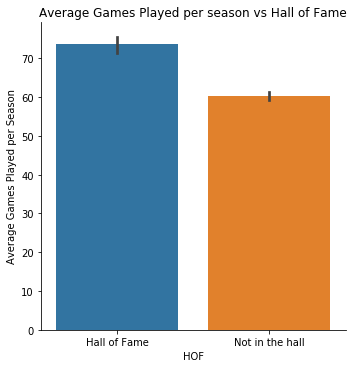

In [17]:
sns.catplot(x="HOF", y="Avg Games Played", data=df_eligible, kind='bar')
#Plot bar graph of games played based on whether or not the player made the hall of fame
plt.title('Average Games Played per season vs Hall of Fame')
plt.xticks([0,1],['Hall of Fame', 'Not in the hall'])
plt.ylabel('Average Games Played per Season')

Text(0.5, 1, 'Position vs Height')

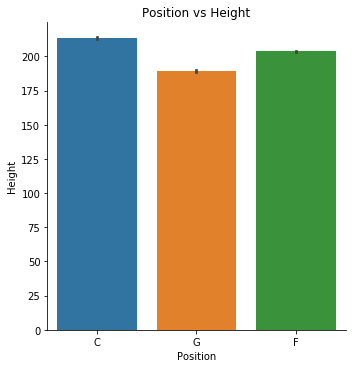

In [21]:
sns.catplot(x="Position", y="Height", data=df_eligible[(df_eligible.Position == 'C') | (df_eligible.Position == 'F')| (df_eligible.Position == 'G')], kind='bar');
plt.title('Position vs Height')

Text(0.5, 1.0, 'Count of Players in the Hall of Fame by Position')

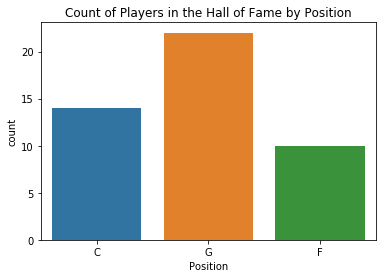

In [26]:
df_HOF= df_eligible[df_eligible['HOF']=='Hall of Fame']
sns.countplot(x="Position", data= df_HOF[(df_HOF.Position == 'C') | (df_HOF.Position == 'F')| (df_HOF.Position == 'G')])
plt.title('Count of Players in the Hall of Fame by Position')

([<matplotlib.axis.XTick at 0x7fb12f5ebe90>,
 <a list of 2 Text xticklabel objects>)

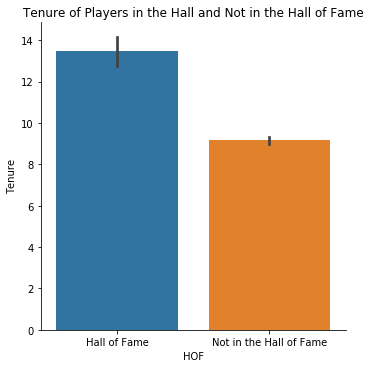

In [30]:
sns.catplot(x="HOF", y="Tenure", data=df_eligible, kind='bar')
plt.title('Tenure of Players in the Hall and Not in the Hall of Fame')
plt.xticks([0,1], ['Hall of Fame', 'Not in the Hall of Fame'])

([<matplotlib.axis.XTick at 0x7fb130207bd0>,
 <a list of 2 Text xticklabel objects>)

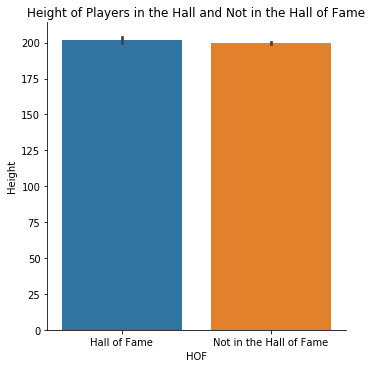

In [89]:
sns.catplot(x="HOF", y="Height", data=df_eligible, kind='bar')
plt.title('Height of Players in the Hall and Not in the Hall of Fame')
plt.xticks([0,1], ['Hall of Fame', 'Not in the Hall of Fame'])

Text(0.5, 1.0, 'Players in the League by Position')

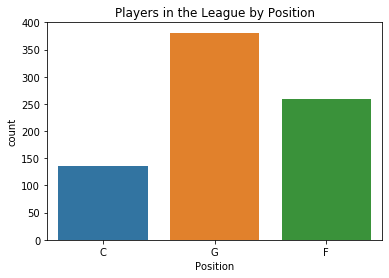

In [88]:
sns.countplot(x="Position", data= df_eligible[(df_eligible.Position == 'C') | (df_eligible.Position == 'F')| (df_eligible.Position == 'G')])
plt.title('Players in the League by Position')

## Hypothesis Testing

Null: There is no relationship between the Position and height of a player

Alternative: There is a relationship between the Position and height of a player

We CAN reject the null hypothesis because chi square statistic (2164.641) is greater than the critical value (192.700)


Chi-squared test

In [32]:
df_chi = df_eligible.groupby('Position')['Height'].value_counts()
df_chi2 = df_chi.unstack()
df_chi2.fillna(0,inplace = True)
df_chi2.head()

Height,160,165,168,170,173,175,178,180,183,185,188,190,193,196,198,201,203,206,208,211,213,216,218,221,224,226,229,231
Position,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,19.0,33.0,42.0,12.0,12.0,4.0,2.0,1.0,2.0,2.0
CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,14.0,28.0,22.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,19.0,66.0,59.0,75.0,29.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,13.0,26.0,57.0,35.0,27.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
FG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,13.0,20.0,29.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:

# contingency table
stat, p, dof, expected = chi2_contingency(df_chi2)
print(expected)

#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')

[[ 0.11083744  0.11083744  0.11083744  0.11083744  0.11083744  0.22167488
   0.88669951  1.33004926  3.54679803  6.65024631  7.09359606  8.6453202
   8.20197044  9.5320197  11.30541872 15.40640394 11.97044335 17.17980296
  12.30295567  9.86453202  6.09605911  1.55172414  1.33004926  0.44334975
   0.33251232  0.11083744  0.22167488  0.22167488]
 [ 0.06732348  0.06732348  0.06732348  0.06732348  0.06732348  0.13464696
   0.53858785  0.80788177  2.1543514   4.03940887  4.30870279  5.25123153
   4.9819376   5.78981938  6.86699507  9.35796388  7.27093596 10.43513957
   7.4729064   5.99178982  3.70279146  0.94252874  0.80788177  0.26929392
   0.20197044  0.06732348  0.13464696  0.13464696]
 [ 0.21264368  0.21264368  0.21264368  0.21264368  0.21264368  0.42528736
   1.70114943  2.55172414  6.8045977  12.75862069 13.6091954  16.5862069
  15.73563218 18.28735632 21.68965517 29.55747126 22.96551724 32.95977011
  23.60344828 18.92528736 11.6954023   2.97701149  2.55172414  0.85057471
   0.6379310

Is there a relationship between the team position of a player and if they will make the Hall of Fame?

Null: There is no relationship between the Position and making the Hall of Fame

Alternative: There is a relationship between the Position and making the Hall of Fame

We CAN reject the null hypothesis because chi square statistic (13.613) is greater than the critical value (12.592)

chi-squared

In [35]:
df_chi = df_eligible.groupby('Position')['HOF'].value_counts()
df_chi2 = df_chi.unstack()
df_chi2.fillna(0,inplace = True)
df_chi2.head()

HOF,0,Hall of Fame
Position,,
C,121,14
CF,73,9
F,249,10
FC,159,10
FG,70,10


In [36]:
# contingency table
stat, p, dof, expected = chi2_contingency(df_chi2)
print(expected)

#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')
    

[[125.91133005   9.08866995]
 [ 76.47947455   5.52052545]
 [241.56321839  17.43678161]
 [157.62233169  11.37766831]
 [ 74.61412151   5.38587849]
 [355.34975369  25.65024631]
 [104.45977011   7.54022989]]
probability=0.950, critical=12.592, stat=13.613)
Dependent (reject H0)
signigicance=0.050, p=0.034,
Dependent (reject H0)


Is there a relationship between average games played and making the Hall of Fame?

Hypothesis Testing:

Null: No statistical difference between average games played and whether or not players make the Hall of Fame

Alternative: There is a statistical difference between average games played and whether or not players make the Hall of Fame

We CAN reject the null hypothesis because our pvalue (9.540838228486468e-22) is less than 0.05 (alpha set at .05)



t-test

In [44]:
no_hof = df_eligible[df_eligible['HOF']=='0']
yes_hof = df_eligible[df_eligible['HOF']=='Hall of Fame']

In [45]:
stats.ttest_ind(no_hof['Avg Games Played'],yes_hof['Avg Games Played'], equal_var = False)

Ttest_indResult(statistic=-11.47202617482838, pvalue=9.540838228486468e-22)

Is there a relationship between height and making the Hall of Fame?

Hypothesis Testing:

Null: No statistical difference between height and whether or not players make the Hall of Fame

Alternative: There is a statistical difference between height and whether or not players make the Hall of Fame

t test

In [82]:
stats.ttest_ind(no_hof['Height'],yes_hof['Height'], equal_var = True)

Ttest_indResult(statistic=-1.6519473176355097, pvalue=0.0988034670035623)

Fail to reject the null hypothesis. On average hall of famers are taller than players who don't make the hall of fame at a statistically significant rate

In [46]:
df_eligible.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 1456
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            1218 non-null   object 
 1   Link              1218 non-null   object 
 2   StartYear         1218 non-null   int64  
 3   EndYear           1218 non-null   int64  
 4   Position          1218 non-null   object 
 5   Tenure            1218 non-null   int64  
 6   Height            1218 non-null   int64  
 7   Weight            1218 non-null   int64  
 8   Birthday          1218 non-null   object 
 9   All_Star_apps     1218 non-null   int64  
 10  All_NBA_apps      1218 non-null   int64  
 11  All_Def_apps      1218 non-null   int64  
 12  HOF               1218 non-null   object 
 13  Games             1218 non-null   int64  
 14  PPG               1218 non-null   float64
 15  TRPG              1218 non-null   float64
 16  APG               1218 non-null   float64


## Data Cleaning

In [47]:
df_eligible['3_pt_pct'] = df_eligible['3_pt_pct'].replace('-', np.nan)

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
df_eligible.All_Star_apps = df_eligible.All_Star_apps.astype('int64')
df_eligible.All_NBA_apps = df_eligible.All_NBA_apps.astype('int64')
df_eligible.All_Def_apps = df_eligible.All_Def_apps.astype('int64')
df_eligible.PPG = df_eligible.PPG.astype('float64')
df_eligible.TRPG = df_eligible.TRPG.astype('float64')
df_eligible.APG = df_eligible.APG.astype('float64')
df_eligible.FG_pct = df_eligible.FG_pct.astype('float64')
df_eligible['3_pt_pct'] = df_eligible['3_pt_pct'].astype('float64')
df_eligible.FT_pct = df_eligible.FT_pct.astype('float64')
df_eligible.eFG_pct = df_eligible.eFG_pct.astype('float64')
df_eligible.PER = df_eligible.PER.astype('float64')
df_eligible.WS = df_eligible.WS.astype('float64')

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
df_eligible.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 1456
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            1218 non-null   object 
 1   Link              1218 non-null   object 
 2   StartYear         1218 non-null   int64  
 3   EndYear           1218 non-null   int64  
 4   Position          1218 non-null   object 
 5   Tenure            1218 non-null   int64  
 6   Height            1218 non-null   int64  
 7   Weight            1218 non-null   int64  
 8   Birthday          1218 non-null   object 
 9   All_Star_apps     1218 non-null   int64  
 10  All_NBA_apps      1218 non-null   int64  
 11  All_Def_apps      1218 non-null   int64  
 12  HOF               1218 non-null   object 
 13  Games             1218 non-null   int64  
 14  PPG               1218 non-null   float64
 15  TRPG              1218 non-null   float64
 16  APG               1218 non-null   float64


In [50]:
df_eligible.Position.value_counts()

G     381
F     259
FC    169
C     135
GF    112
CF     82
FG     80
Name: Position, dtype: int64

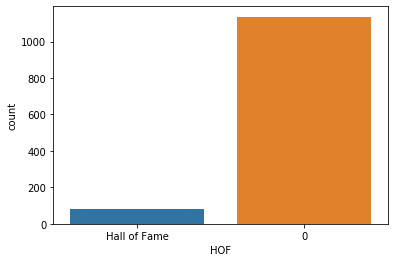

In [51]:
sns.countplot(df_eligible.HOF)

In [52]:
df_eligible.HOF.value_counts()

0               1136
Hall of Fame      82
Name: HOF, dtype: int64

In [53]:
df_eligible.columns

Index(['Player', 'Link', 'StartYear', 'EndYear', 'Position', 'Tenure',
       'Height', 'Weight', 'Birthday', 'All_Star_apps', 'All_NBA_apps',
       'All_Def_apps', 'HOF', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct',
       '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS', 'Avg Games Played'],
      dtype='object')

## Feature Engineering

In [55]:
df_eligible['is_guard'] = df_eligible.Position.map(lambda x: 'G' in x)
df_eligible['is_forward'] = df_eligible.Position.map(lambda x: 'F' in x)
df_eligible['is_center'] = df_eligible.Position.map(lambda x: 'C' in x)
df_eligible['is_hybrid'] = df_eligible.Position.map(lambda x: len(x) > 1)

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

## Modeling

In [56]:
X = df_eligible[['Tenure', 'Height', 'Weight', 'All_Star_apps', 'All_NBA_apps', 'All_Def_apps', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct', '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS', 'Avg Games Played', 'is_guard', 'is_forward', 'is_center', 'is_hybrid']]
y = df_eligible.HOF
y = y.replace('Hall of Fame', 1)
y = y.astype('int64')

In [57]:
X['Total_points'] = X.PPG * X.Games

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
X = X.fillna(0)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [66]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
y_train_preds_knn = knn.predict(X_train)
f1_train_knn = f1_score(y_train,y_train_preds_knn)
y_preds_knn = knn.predict(X_test)
f1_test_knn = f1_score(y_test, y_preds_knn)
print(f1_train_knn, f1_test_knn)

0.7884615384615385 0.6875


In [68]:
logreg = LogisticRegression(class_weight = 'balanced', random_state = 1, n_jobs = -1)
logreg.fit(X_train, y_train)
y_train_preds_logreg = logreg.predict(X_train)
f1_train_logreg = f1_score(y_train, y_train_preds_logreg)
y_preds_logreg = logreg.predict(X_test)
f1_test_logreg = f1_score(y_test, y_preds_logreg)
print(f1_train_logreg, f1_test_logreg)

0.7453416149068324 0.6296296296296297


In [69]:
dt = DecisionTreeClassifier(random_state = 1, class_weight = 'balanced', max_depth = 7)
dt.fit(X_train, y_train)
y_train_preds_dt = dt.predict(X_train)
f1_train_dt = f1_score(y_train, y_train_preds_dt)
y_preds_dt = dt.predict(X_test)
f1_test_dt = f1_score(y_test, y_preds_dt)
print(f1_train_dt, f1_test_dt)

0.9618320610687023 0.8095238095238095


In [70]:
list(zip(dt.feature_importances_,X.columns))

[(0.004323406362725611, 'Tenure'),
 (0.023854075306967135, 'Height'),
 (0.0023219235348049777, 'Weight'),
 (0.7872048336299977, 'All_Star_apps'),
 (0.0, 'All_NBA_apps'),
 (0.002252527892209658, 'All_Def_apps'),
 (0.03205761256064736, 'Games'),
 (7.127968052890638e-18, 'PPG'),
 (0.0, 'TRPG'),
 (0.011350197723924338, 'APG'),
 (0.008657704066668583, 'FG_pct'),
 (0.022422416082663623, '3_pt_pct'),
 (0.005689283881228838, 'FT_pct'),
 (0.008288505732849217, 'eFG_pct'),
 (0.04880722355294458, 'PER'),
 (0.04047677370349116, 'WS'),
 (0.002293515968877186, 'Avg Games Played'),
 (0.0, 'is_guard'),
 (0.0, 'is_forward'),
 (1.5585092501526175e-17, 'is_center'),
 (3.1698493223443076e-17, 'is_hybrid'),
 (0.0, 'Total_points')]

<function matplotlib.pyplot.show(*args, **kw)>

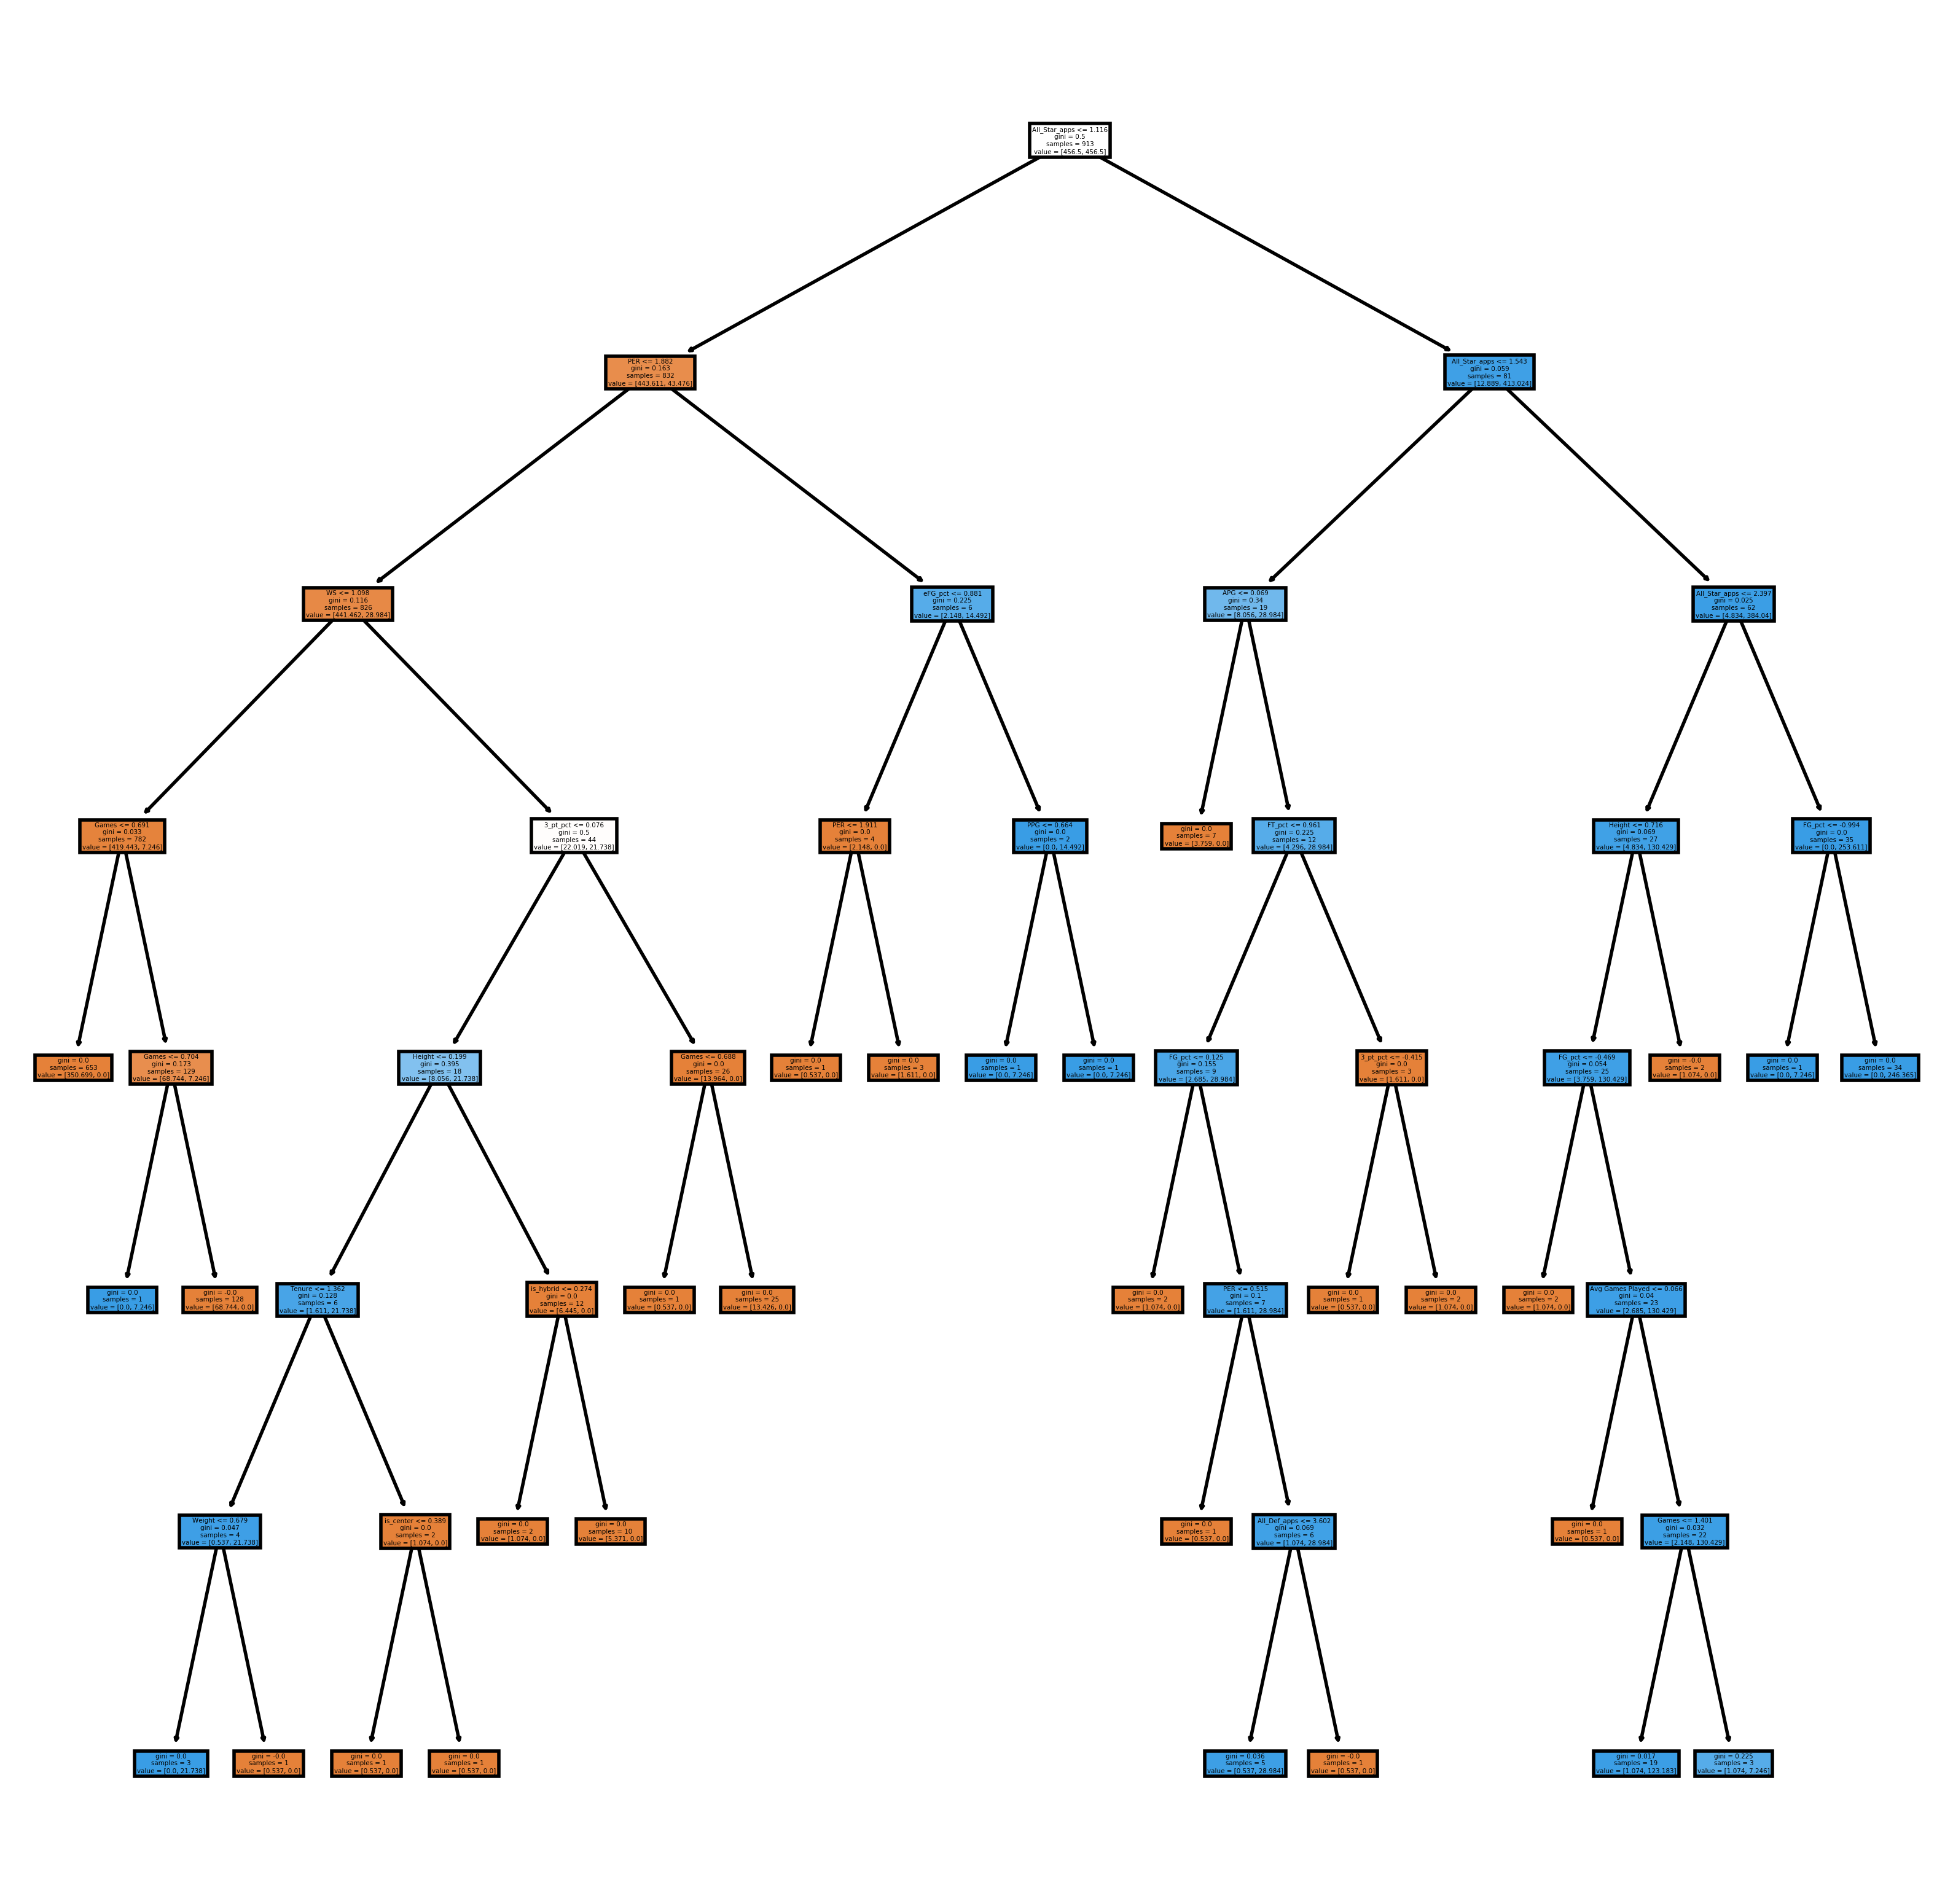

In [71]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,10), dpi=400)
tree.plot_tree(dt, filled = True, feature_names = X.columns)
plt.show

In [100]:
params = {'max_depth' : [2,3,4,7], 'min_samples_split' : [10,11,12,13,14], 'min_samples_leaf' : [2,3,4], 'max_features': [12,13,14], 'max_leaf_nodes' : [20,25,30,35,None]}
dtc = DecisionTreeClassifier(random_state=1)
grid_tree = GridSearchCV(dtc, params, cv=5, scoring='f1', n_jobs = -1, verbose = 1)
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4461 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    9.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 7],
                         'max_features': [12, 13, 14],
                         'max_leaf_nodes': [20, 25, 30, 35, None],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [10, 11, 12, 13, 14]},
             scoring='f1', verbose=1)

In [101]:
grid_tree.best_score_

0.8185925925925925

In [102]:
grid_tree.best_params_

{'max_depth': 3,
 'max_features': 13,
 'max_leaf_nodes': None,
 'min_samples_leaf': 3,
 'min_samples_split': 11}

In [103]:
grid_preds = grid_tree.predict(X_test)
f1_score(y_test, grid_preds)

0.7777777777777778

In [76]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 1, class_weight = 'balanced')
rf.fit(X_train, y_train)
y_train_preds_rf = rf.predict(X_train)
f1_train_rf = f1_score(y_train, y_train_preds_rf)
y_preds_rf = rf.predict(X_test)
f1_test_rf = f1_score(y_test, y_preds_rf)
print(f1_train_rf, f1_test_rf)

1.0 0.742857142857143


In [77]:
xg = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 1)
xg.fit(X_train, y_train)
y_train_preds_xg = xg.predict(X_train)
f1_train_xg = f1_score(y_train, y_train_preds_xg)
y_preds_xg = xg.predict(X_test)
f1_test_xg = f1_score(y_test, y_preds_xg)
print(f1_train_xg, f1_test_xg)

1.0 0.717948717948718


In [104]:
final = DecisionTreeClassifier(max_depth = 3, max_features = 13, max_leaf_nodes = None, min_samples_leaf = 3, min_samples_split = 11)
final.fit(X,y)
y_preds = final.predict(X)
f1_score(y, y_preds)

0.8333333333333334

<function matplotlib.pyplot.show(*args, **kw)>

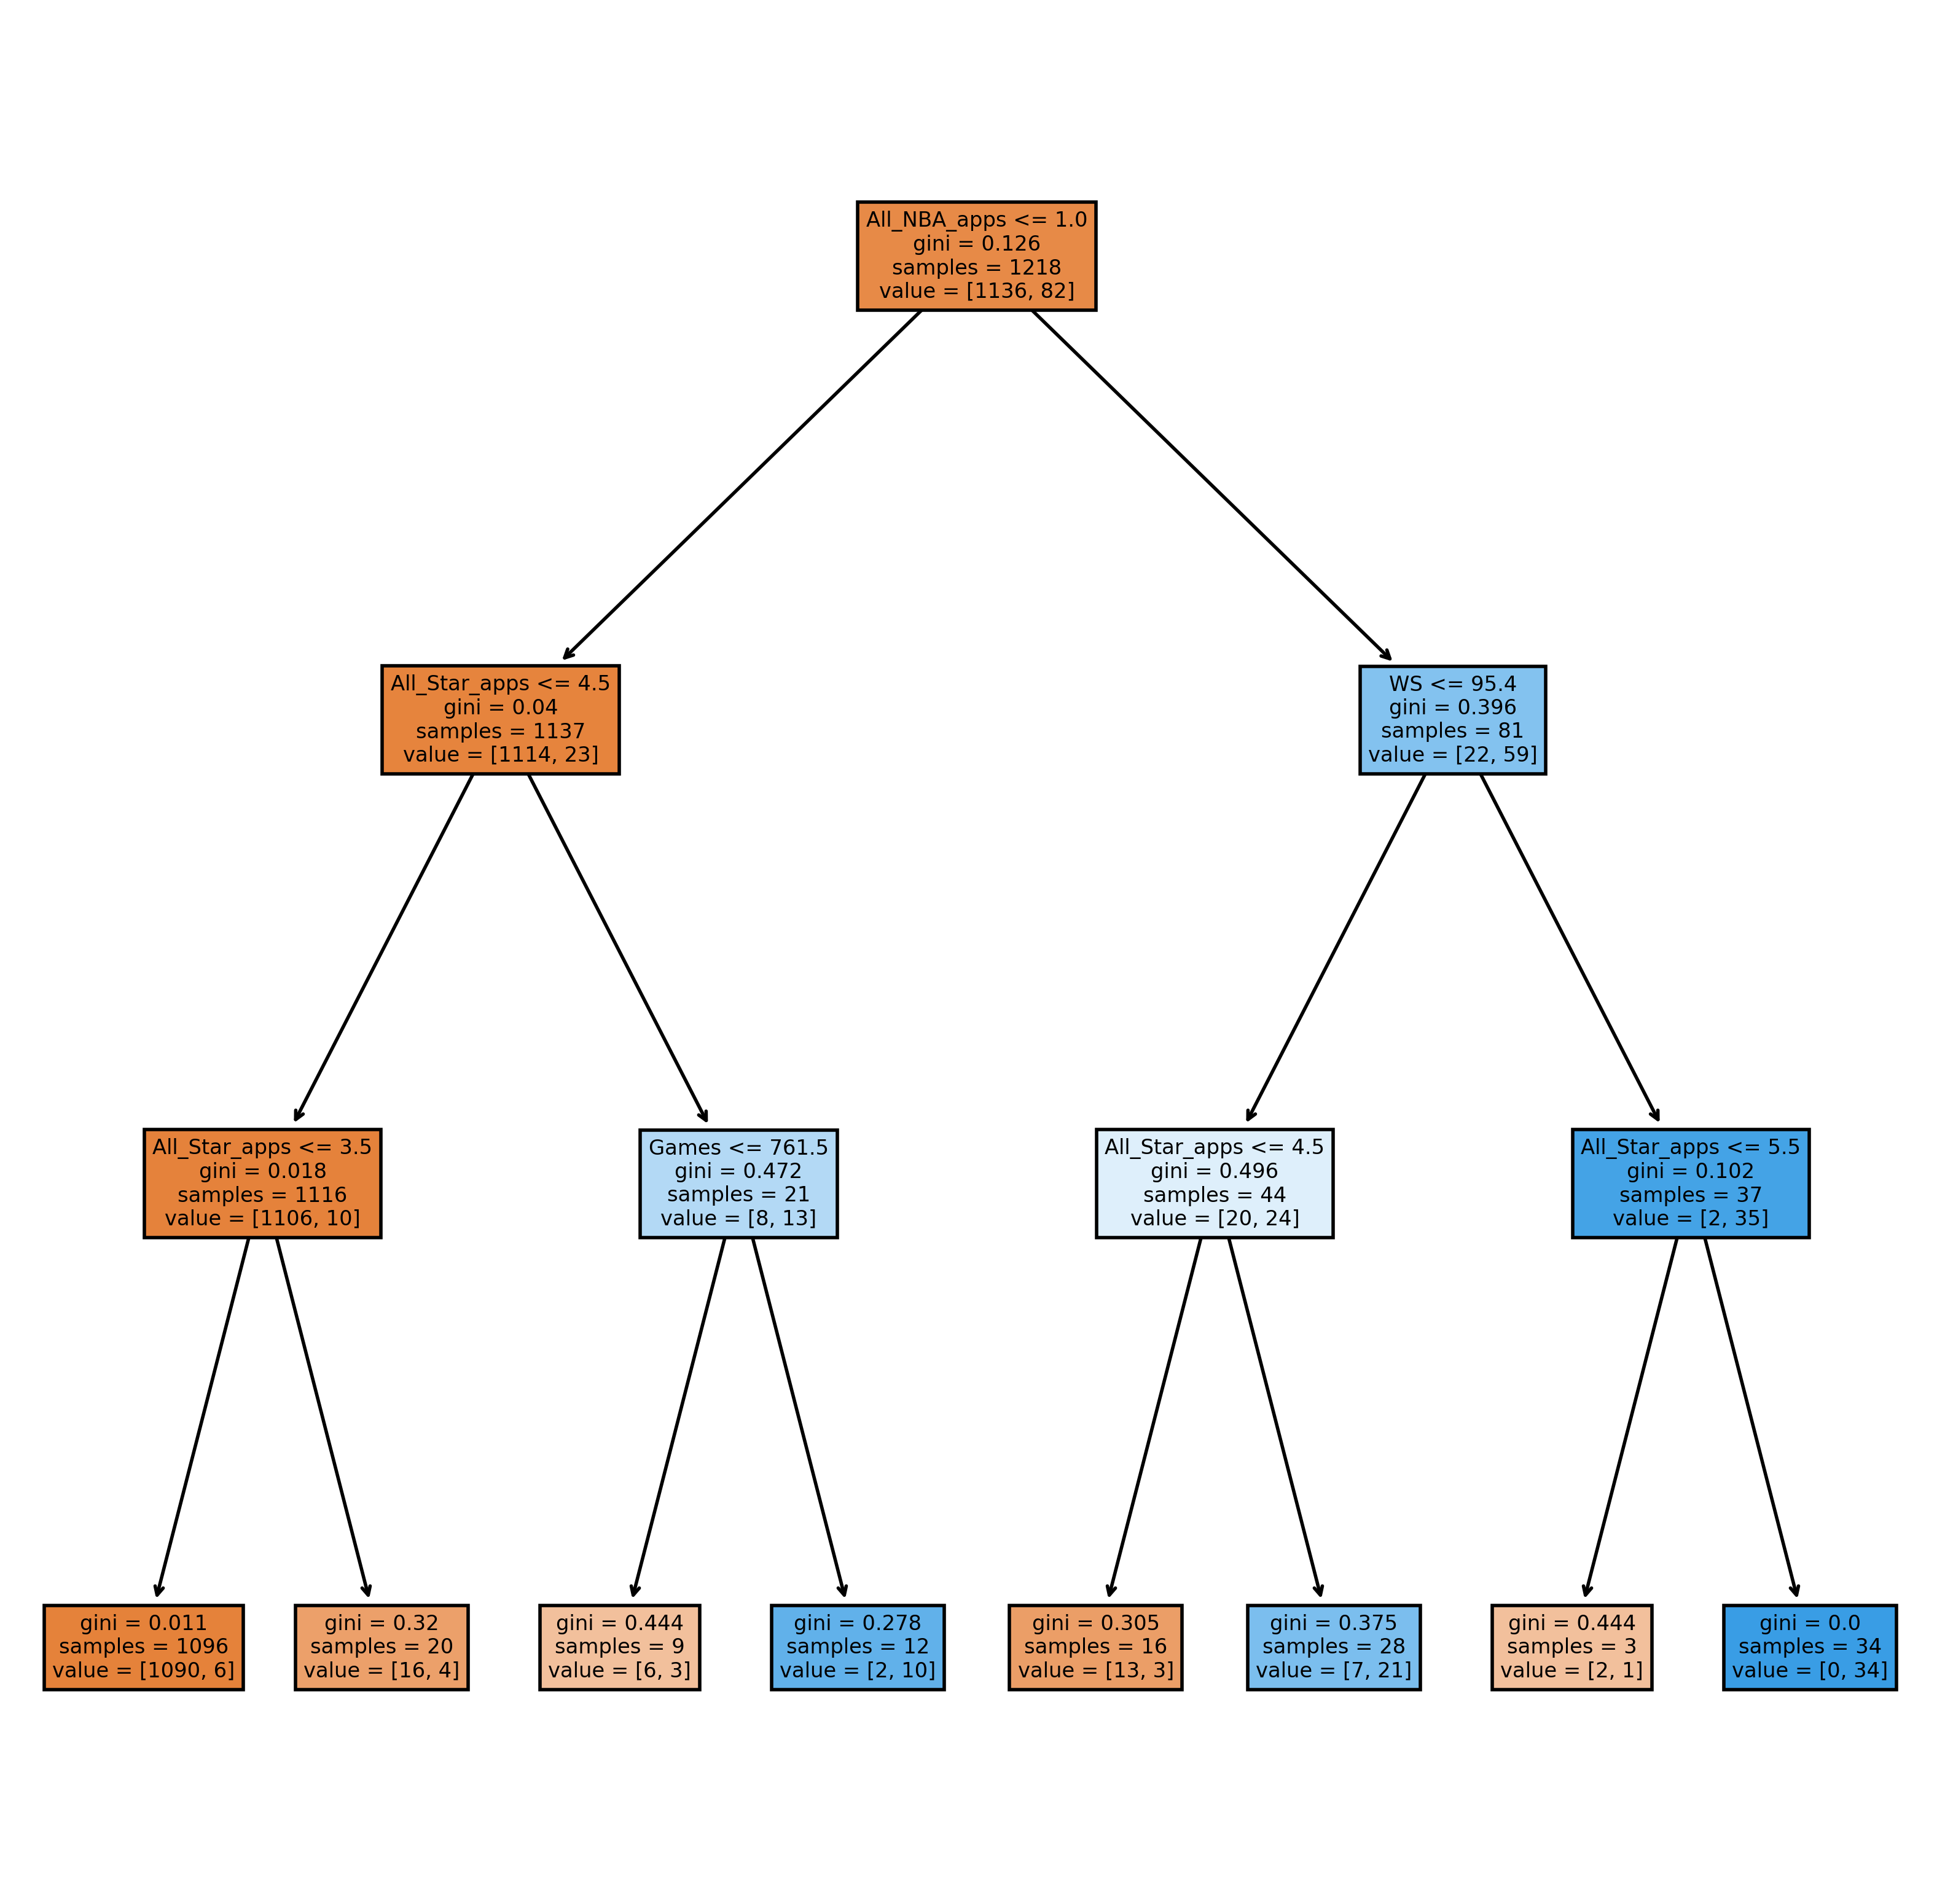

In [105]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,10), dpi=400)
tree.plot_tree(final, filled = True, feature_names = X.columns)
plt.show